# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.835384,True,5.291288
1,-0.373036,False,-2.385761
2,-0.000841,False,-0.505251
3,-0.506175,True,2.805259
4,0.076095,True,6.181098
...,...,...,...
995,-0.527992,False,-1.103840
996,-0.909055,False,0.048373
997,1.049843,True,8.138861
998,0.109887,True,5.004557


<AxesSubplot: xlabel='v0'>

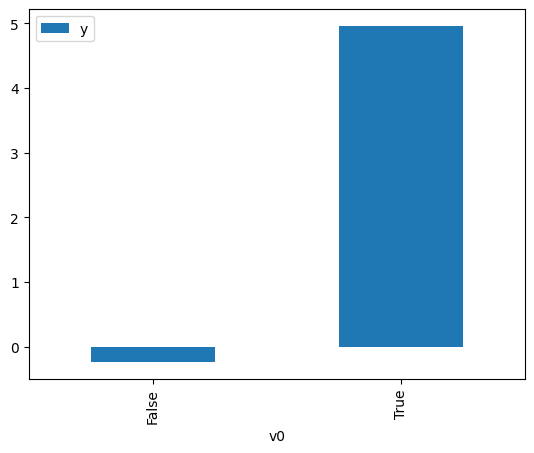

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

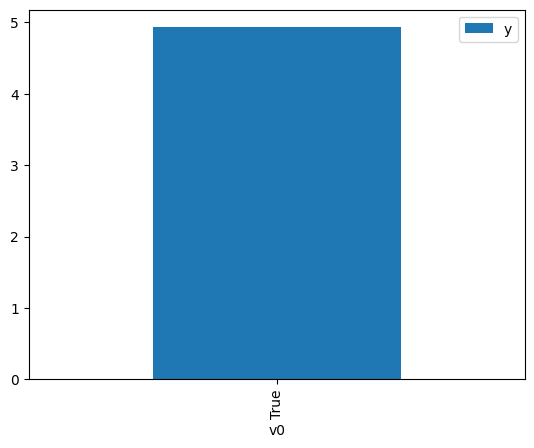

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.531890,False,1.216860,0.729741,1.370348
1,-1.621161,False,-2.366467,0.947761,1.055118
2,0.412678,False,1.247566,0.341056,2.932070
3,-1.130786,False,-1.473641,0.885003,1.129939
4,1.646352,False,1.832042,0.056460,17.711504
...,...,...,...,...,...
995,-0.417306,False,-1.379264,0.688458,1.452521
996,-0.167489,False,-0.833731,0.588079,1.700452
997,-0.982083,False,-0.935502,0.855774,1.168532
998,0.576705,False,0.792017,0.279801,3.573974


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.767580,True,4.779087,0.196946,5.077545
1,1.014064,True,4.118765,0.846878,1.180807
2,0.612249,True,5.319755,0.732552,1.365090
3,-1.845153,True,2.537365,0.035916,27.842940
4,-1.055865,True,2.458599,0.129019,7.750800
...,...,...,...,...,...
995,1.429134,True,5.744244,0.919548,1.087491
996,-1.608487,True,2.798619,0.053347,18.745140
997,-0.638699,True,3.969651,0.235034,4.254706
998,-0.647379,True,4.667120,0.232315,4.304494


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              7002.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):                        0.00
Time:                        21:45:20   Log-Likelihood:                         -1439.7
No. Observations:                1000   AIC:                                      2883.
Df Residuals:                     998   BIC:                                      2893.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9264      0.033     28.451      0.000       0.863       0.990
x2             4.9771      0.051     97.377      0.000       4.877       5.077
==============================================================================
Omnibus:                        2.643   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.267   Jarque-Bera (JB):                2.394
Skew:                          -0.043   Prob(JB):                        0.302
Kurtosis:                       2.777   Cond. No.                         1.81
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""